In [1]:
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors as mcolors

import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
# from pipeline.python.utils import natural_keys, label_figure, convert_range, add_meta_to_df
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse




/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", lin

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 65

In [2]:
%matplotlib notebook

In [3]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5


# Set plot params

In [4]:
putils.set_plot_params(color='k')
dpi = 150
visual_areas, area_colors = putils.set_threecolor_palette()
area_colors

{'Li': 'dodgerblue', 'Lm': 'orange', 'V1': 'magenta'}

# Output dir

In [5]:
#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])

#### Filter RF datasets (no repeats)
filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats


In [6]:
genstats_dir = os.path.join(outdir, 'general-stats', '%s' % filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print(genstats_dir)

basedir = os.path.split(genstats_dir)[0]

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats


# Load datasets

In [7]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

reload(rfutils)
reload(aggr)

scale_sigma = False
reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

filter_by='drop_repeats' #'None'
filter_str = '%s_%s' % (filter_by, reliable_str)
print(filter_str)

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only, verbose=False,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')
assert 'anisotropy' in r_df.columns
print(r_df.shape)

drop_repeats_reliable
droppin repeats
[filter_by=drop_repeats] Excluding 24 total repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4
(1881, 28)


# Select 1 dset for now

In [9]:
visual_area = 'V1'

animalid = 'JC097'
session = '20190617'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

rdf = r_df[r_df['datakey']==datakey].copy()
print(datakey, rdf.shape)

('20190617_JC097_fov1', (89, 28))


# Screen info

In [10]:
screeninfo = aggr.get_aggregate_stimulation_info(rdf)

screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


Stimuli presented at coords: (25, 0)
avg pix/deg: 16.05


In [11]:
rdf['experiment'].unique()

array(['rfs'], dtype=object)

<IPython.core.display.Javascript object>


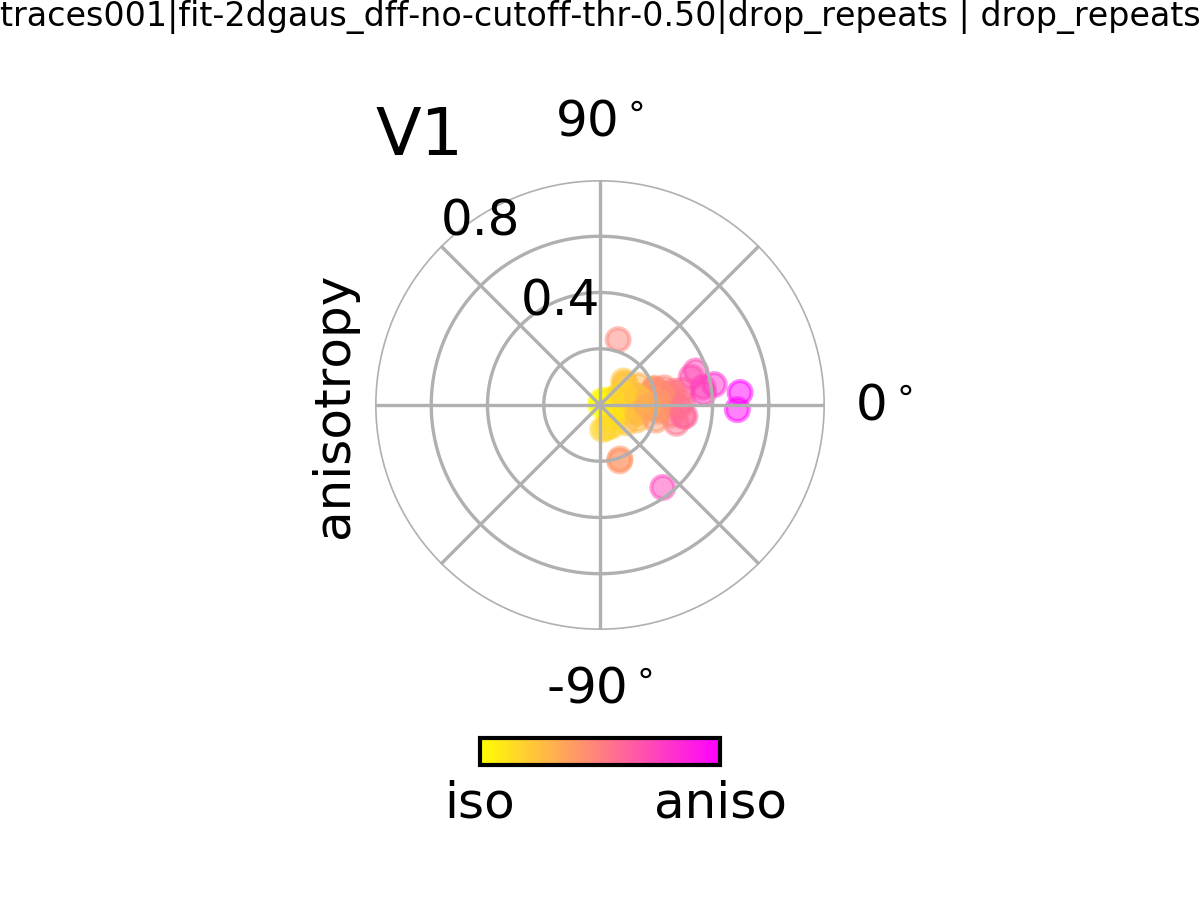

In [35]:
metric = 'anisotropy' #'ratio_xy'
cmap='spring_r'
# ---------------------------------------------------

norm = mpl.colors.Normalize(vmin=0, vmax=1)
iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = pl.subplots(1, subplot_kw=dict(projection='polar'), figsize=(4,3), dpi=dpi)

thetas = rdf['theta_Mm_c'].values #% np.pi
ratios = rdf[metric].values
ax.scatter(thetas, ratios, s=30, c=ratios, cmap=cmap, alpha=0.5) # c=thetas, cmap='hsv', alpha=0.7)

ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_title(visual_area, fontsize=16, loc='left')

# ax.set_theta_direction(1)
ax.set_title(visual_area, fontsize=16, loc='left')
if 'anisotropy' in metric:
    ax.set_ylim([0, 0.8]) # 0.33 = major is double minor axis
else:
    ax.set_ylim([0, 4.1])

ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
ax.set_rlabel_position(135) #315)
ax.set_xlabel('')
ax.set_yticklabels(['', 0.4, '', 0.8])

ax.set_ylabel(metric, fontsize=12)

# Grid lines and such
ax.spines['polar'].set_visible(False)
#ax.yaxis.grid(False)
#ax.set_thetagrids([])
    
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.2, bottom=0.3, top=0.8, hspace=0.5)

# Colorbar
iso_cmap._A = []
cbar_ax = fig.add_axes([0.4, 0.15, 0.2, 0.03])
cbar = fig.colorbar(iso_cmap, cax=cbar_ax, orientation='horizontal', ticks=[0, 1])
cbar.ax.set_xticklabels(['iso', 'aniso'])  # horizontal colorbar
cbar.ax.tick_params(which='both', size=0)

putils.label_figure(fig, '%s | %s' % (data_id, filter_str))

In [36]:
def get_aniso_index(r_df):

    sins = abs(np.sin(r_df['theta_Mm_c']))
    sins_c = putils.convert_range(sins, oldmin=0, oldmax=1, newmin=-1, newmax=1)
    r_df['aniso_index'] = sins_c * r_df['anisotropy']

    print(r_df['aniso_index'].min(), r_df['aniso_index'].max())
    
    return r_df

def assign_saturation(hue_param, saturation_param, min_v=0, max_v=1):
    norm_ai = (saturation_param - min_v) / (max_v - min_v)
    theta_rgb = scalar_cmap.to_rgba(abs(np.sin(hue_param)))
    theta_hsv = mcolors.rgb_to_hsv(theta_rgb[0:3])
    theta_hsv[1] = norm_ai
    theta_col = mcolors.hsv_to_rgb(theta_hsv)     
    return theta_col

In [41]:

rdf = get_aniso_index(rdf)
print(rdf['aniso_index'].min(), rdf['aniso_index'].max())

(-0.45589097497839426, 0.22361114398412604)
(-0.45589097497839426, 0.22361114398412604)


<IPython.core.display.Javascript object>


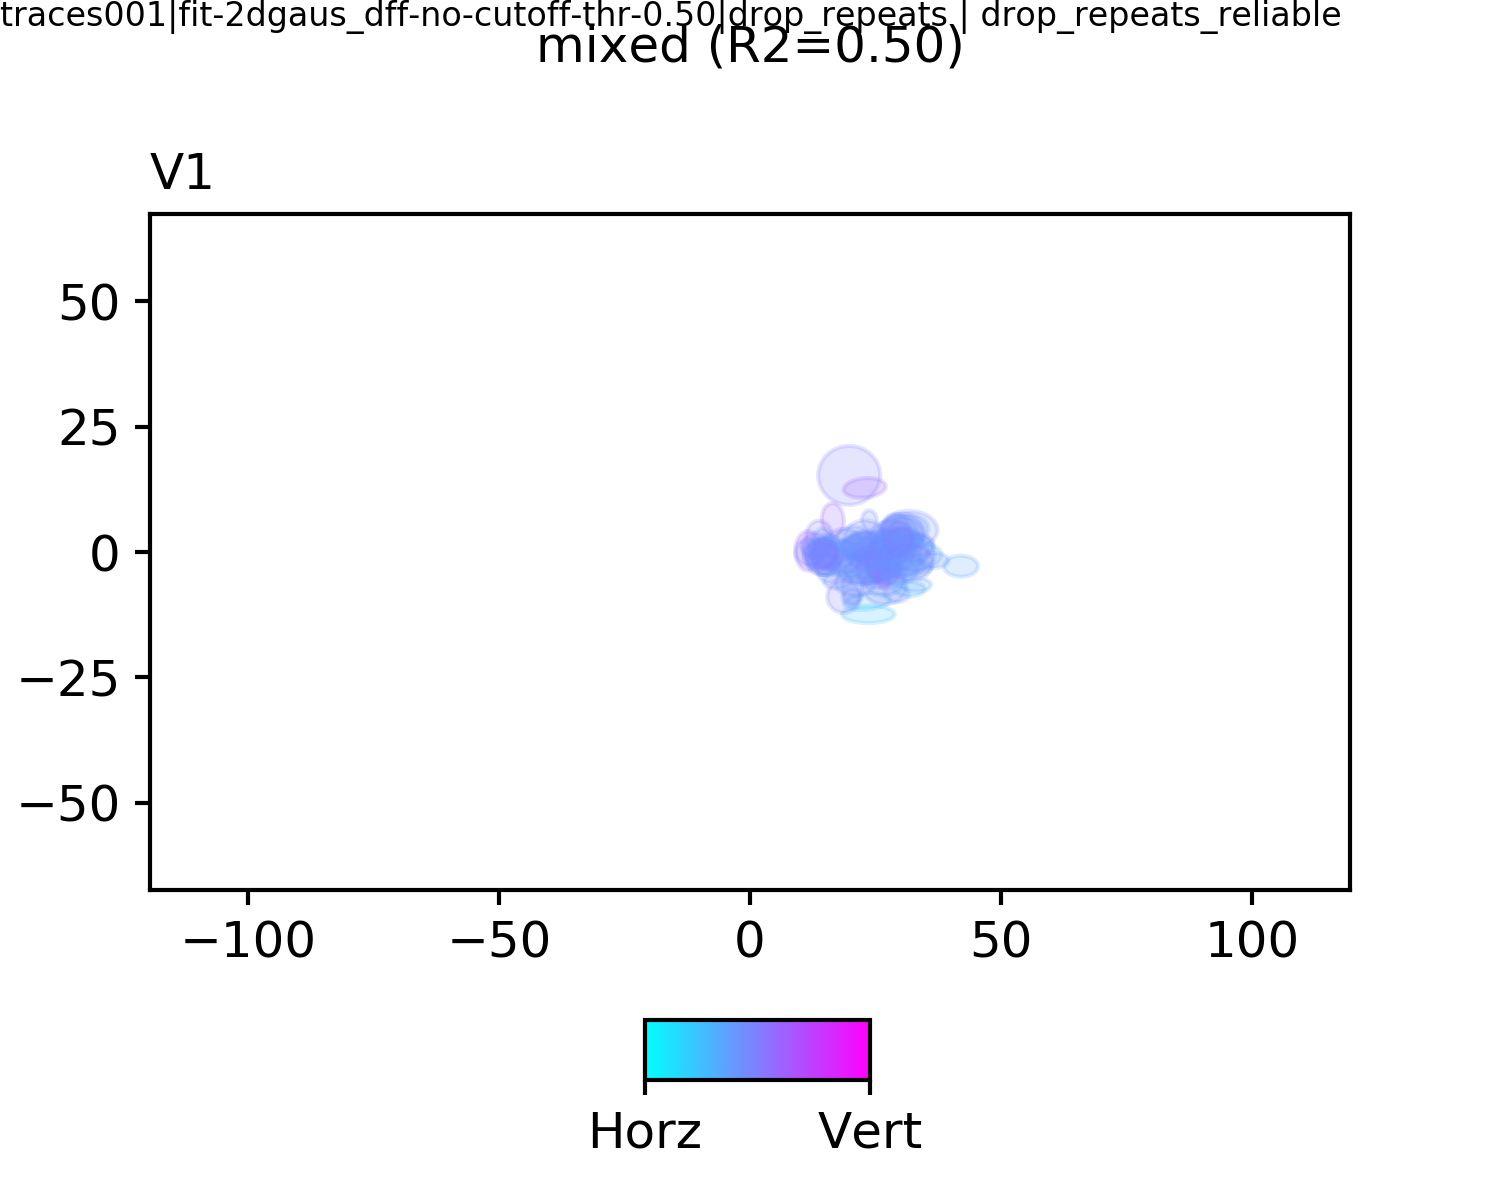

In [45]:
filter_str='drop_repeats_reliable'
# ---------------------------------------------------
hue_param = 'aniso_index'
shape_str = 'ellipse'
cmap = cm.cool if hue_param in ['angle', 'aniso_index'] else cm.spring_r
    
n_plot_rfs = -1
n_plot_skip = 1

axis_lw=2
axis_alpha=0.5
ellipse_lw=1
ellipse_alpha=0.2

borderpad=0
metric = 'anisotropy' if hue_param=='angle' else hue_param

sat_param = 'aniso' if hue_param=='angle' else 'none'
markersize = 5 if shape_str=='centroid' else 2
markeralpha = 0.3 if shape_str=='centroid' else 1.0
shape_scale = 0.8 if shape_str=='ellipse' else 1.0

min_ai = -0.8 if metric=='aniso_index' else 0 
max_ai = 0.8 if metric=='aniso_index' else 1
r2 = 0.5

norm = mpl.colors.Normalize(vmin=min_ai, vmax=max_ai)
scalar_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = pl.subplots(1, figsize=(5,4), dpi=dpi)

ax.set_xlim([screenleft-borderpad, screenright+borderpad])
ax.set_ylim([screenbottom-borderpad, screentop+borderpad])

rf_indices = rdf.index.tolist()[0::n_plot_skip] #n_plot_rfs]
for i in rf_indices:

    x0, y0, std_x, std_y, theta, theta_c, aniso, aniso_v = rdf[[
        'x0', 'y0', 'std_x', 'std_y', 'theta', 'theta_Mm_c', metric, 'anisotropy']].loc[i]

    if hue_param == 'angle':
        theta_col = assign_saturation(theta_c, aniso, min_v=min_ai, max_v=max_ai)
    elif hue_param == 'aniso_index':
        theta_col = scalar_cmap.to_rgba(aniso)
    elif hue_param == 'aniso':
        theta_col = scalar_cmap.to_rgba(aniso)

    if 'centroid' in shape_str:
        ax.plot(x0, y0, marker='o', color=theta_col, alpha=markeralpha, markersize=markersize)

    if 'ellipse' in shape_str:
        el = Ellipse((x0, y0), width=std_x*shape_scale, height=std_y*shape_scale, 
                     angle=theta, edgecolor=theta_col, facecolor=theta_col, alpha=ellipse_alpha, lw=ellipse_lw)
        ax.add_artist(el)

    if 'major' in shape_str:
        M = vdf[['std_x', 'std_y']].loc[i].max()  
        m = vdf[['std_x', 'std_y']].loc[i].min()  
        F = M/2.
        xe = F * np.cos(np.deg2rad(theta)) if std_x>std_y else -F * np.sin(np.deg2rad(theta))
        ye = F * np.sin(np.deg2rad(theta)) if std_x>std_y else F * np.cos(np.deg2rad(theta))
        ax.plot([x0, x0+xe], [y0, y0+ye], color=theta_col, alpha=axis_alpha, lw=axis_lw)

    if 'minor' in shape_str:
        xe2 = (m/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else -(m/2.) * np.cos(np.deg2rad(180-theta))
        ye2 = (m/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (m/2.) * np.sin(np.deg2rad(180-theta))
        ax.plot([x0, x0+xe2], [y0, y0+ye2], color=theta_col, alpha=axis_alpha, lw=axis_lw)

ax.set_title(visual_area, loc='left')
ax.set_aspect('equal')

scalar_cmap._A = []
cbar_ax = fig.add_axes([0.43, 0.1, 0.15, 0.05])
cbar = fig.colorbar(scalar_cmap, cax=cbar_ax, orientation='horizontal', ticks=[min_ai, max_ai])
if hue_param=='angle':
    cbar.ax.set_xticklabels(['Horz', 'Vert'])  # horizontal colorbar
elif hue_param=='aniso_index':
    cbar.ax.set_xticklabels(['Horz', 'Vert'])  # horizontal colorbar
else:
    cbar.ax.set_xticklabels(['Iso', 'Aniso'])  # horizontal colorbar

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.3, bottom=0.2)
pl.suptitle('%s (R2=%.2f)' % (rfname, r2))

putils.label_figure(fig, '%s | %s' % (data_id, filter_str))


In [12]:
def get_lin_coords():
    """
    **From: https://github.com/zhuangjun1981/retinotopic_mapping
    
    Monitor initialiser

    Parameters
    ----------
    resolution : tuple of two positive integers
        value of the monitor resolution, (pixel number in height, pixel number in width)
    dis : float
         distance from eyeball to monitor (in cm)
    mon_width_cm : float
        width of monitor (in cm)
    mon_height_cm : float
        height of monitor (in cm)
    C2T_cm : float
        distance from gaze center to monitor top
    C2A_cm : float
        distance from gaze center to anterior edge of the monitor
    center_coordinates : tuple of two floats
        (altitude, azimuth), in degrees. the coordinates of the projecting point
        from the eye ball to the monitor. This allows to place the display monitor
        in any arbitrary position.
    visual_field : str from {'right','left'}, optional
        the eye that is facing the monitor, defaults to 'right'
        
    """
    mon_height_cm = 58.
    mon_width_cm = 103.
    resolution = [1080, 1920]
    visual_field = 'left'
    
    C2T_cm = mon_height_cm/2. #np.sqrt(dis**2 + mon_height_cm**2)
    C2A_cm = mon_width_cm/2.
    
    # distance form projection point of the eye to bottom of the monitor
    C2B_cm = mon_height_cm - C2T_cm
    # distance form projection point of the eye to right of the monitor
    C2P_cm = -C2A_cm #mon_width_cm - C2A_cm

    map_coord_x, map_coord_y = np.meshgrid(range(resolution[1]),
                                           range(resolution[0]))

    if visual_field == "left":
        #map_x = np.linspace(C2A_cm, -1.0 * C2P_cm, resolution[1])
        map_x = np.linspace(C2P_cm, C2A_cm, resolution[1])

    if visual_field == "right":
        map_x = np.linspace(-1 * C2A_cm, C2P_cm, resolution[1])

    map_y = np.linspace(C2T_cm, -1.0 * C2B_cm, resolution[0])
    old_map_x, old_map_y = np.meshgrid(map_x, map_y, sparse=False)

    lin_coord_x = old_map_x
    lin_coord_y = old_map_y
    
    return lin_coord_x, lin_coord_y
    

In [13]:
lin_coord_x, lin_coord_y = get_lin_coords()

In [14]:
lin_coord_x.shape

(1080, 1920)

<IPython.core.display.Javascript object>


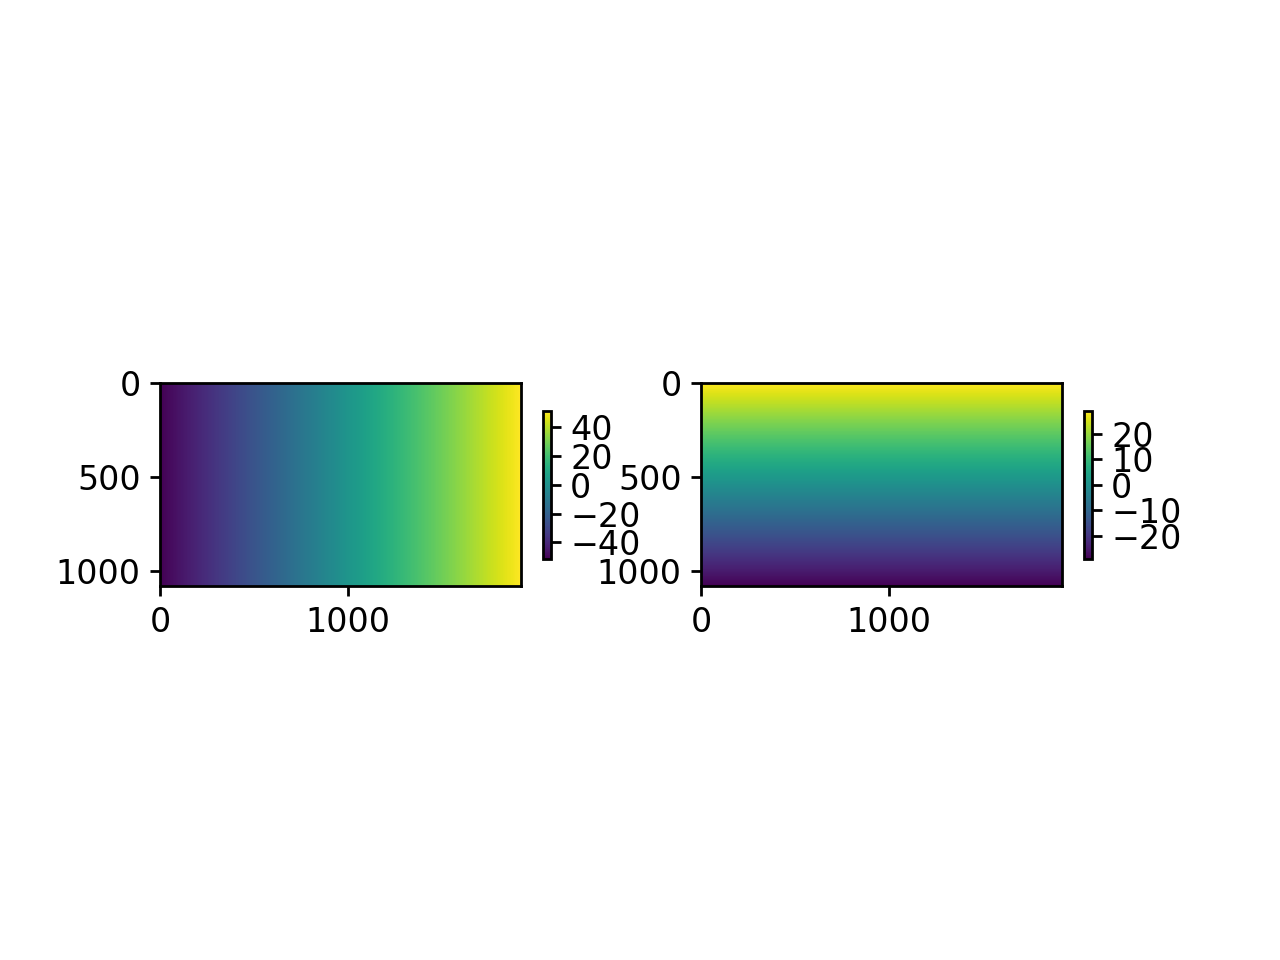

In [15]:
fig, axn = pl.subplots(1,2)
im0 = axn[0].imshow(lin_coord_x)
pl.colorbar(im0, ax=axn[0], shrink=0.2)

im1 = axn[1].imshow(lin_coord_y)
pl.colorbar(im1, ax=axn[1], shrink=0.2)

In [16]:
def remap(lin_coord_x, lin_coord_y, center_coordinates=[0, 0], resolution=[1080, 1920], dis=30.):
    """
    **From: https://github.com/zhuangjun1981/retinotopic_mapping
    
    warp the linear pixel coordinates to a spherical corrected representation.
    Function is called when the monitor object is initialized and populate
    the `deg_coord_x` and `deg_coord_y` attributes.
    """
    map_coord_x, map_coord_y = np.meshgrid(range(resolution[1]),
                                           range(resolution[0]))  
    
    new_map_x = np.zeros(resolution, dtype=np.float32)
    new_map_y = np.zeros(resolution, dtype=np.float32)
    for j in range(resolution[1]):
        new_map_x[:, j] = ((180.0 / np.pi) *
                           np.arctan(lin_coord_x[0, j] / dis))
        dis2 = np.sqrt(np.square(dis) +
                       np.square(lin_coord_x[0, j]))

        for i in range(resolution[0]):
            new_map_y[i, j] = ((180.0 / np.pi) *
                               np.arctan(lin_coord_y[i, 0] / dis2))

    deg_coord_x = new_map_x + center_coordinates[1]
    deg_coord_y = new_map_y + center_coordinates[0]
    
    return deg_coord_x, deg_coord_y

In [83]:

def plot_remap(lin_coord_x, lin_coord_y, deg_coord_x, deg_coord_y, resolution=[1080, 1920]):

    mapcorX, mapcorY = np.meshgrid(range(resolution[1]), range(resolution[0]))

    f1 = pl.figure(figsize=(8, 4))
    f1.suptitle('Remap monitor', fontsize=14, fontweight='bold')

    OMX = pl.subplot(221)
    OMX.set_title('Linear Map X (cm)')
    currfig = pl.imshow(lin_coord_x)
    levels1 = range(int(np.floor(np.nanmin(lin_coord_x) / 10) * 10),
                    int((np.ceil(np.nanmax(lin_coord_x) / 10) + 1) * 10), 10)
    im1 = pl.contour(mapcorX, mapcorY, lin_coord_x, levels1, colors='k', linewidth=2)
    f1.colorbar(currfig, ticks=levels1)
    pl.gca().set_axis_off()

    OMY = pl.subplot(222)
    OMY.set_title('Linear Map Y (cm)')
    currfig = pl.imshow(lin_coord_y)
    levels2 = range(int(np.floor( np.nanmin(lin_coord_y) / 10) * 10),
                    int((np.ceil( np.nanmax(lin_coord_y) / 10) + 1) * 10), 10)
    im2 = pl.contour(mapcorX, mapcorY, lin_coord_y, levels2, colors='k', linewidth=2)
    f1.colorbar(currfig, ticks=levels2)
    pl.gca().set_axis_off()

    NMX = pl.subplot(223)
    NMX.set_title('Spherical Map X (deg)')
    currfig = pl.imshow(deg_coord_x)
    levels3 = range(int(np.floor( np.nanmin(deg_coord_x) / 10) * 10),
                    int((np.ceil( np.nanmax(deg_coord_x) / 10) + 1) * 10), 10)
    im3 = pl.contour(mapcorX, mapcorY, deg_coord_x, levels3, colors='k', linewidth=2)
    #        plt.clabel(im3, levels3, fontsize = 10, inline = 1, fmt='%2.1f')
    f1.colorbar(currfig, ticks=levels3)
    pl.gca().set_axis_off()
    #
    NMY = pl.subplot(224)
    NMY.set_title('Spherical Map Y (deg)')
    currfig = pl.imshow(deg_coord_y)
    levels4 = range(int(np.floor( np.nanmin(deg_coord_y) / 10) * 10),
                    int((np.ceil( np.nanmax(deg_coord_y) / 10) + 1) * 10), 10)
    im4 = pl.contour(mapcorX, mapcorY, deg_coord_y, levels4, colors='k', linewidth=2)
    #        plt.clabel(im4, levels4, fontsize = 10, inline = 1, fmt='%2.1f')
    f1.colorbar(currfig, ticks=levels4)
    pl.gca().set_axis_off()


In [18]:
remap_x, remap_y = remap(lin_coord_x, lin_coord_y)
print(remap_x.shape, remap_y.shape)


((1080, 1920), (1080, 1920))


<IPython.core.display.Javascript object>


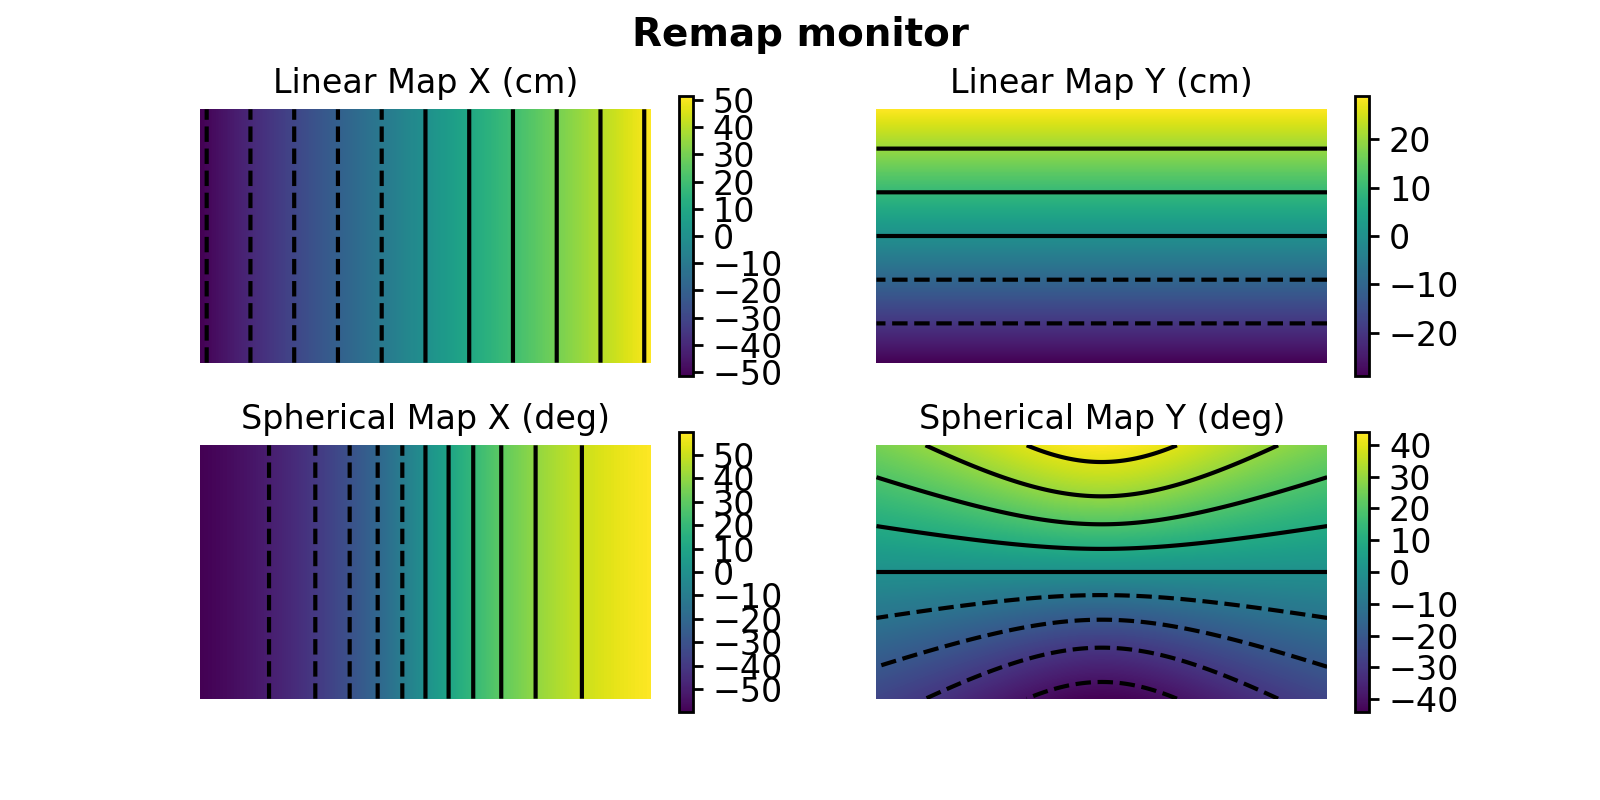

In [19]:
plot_remap(lin_coord_x, lin_coord_y, remap_x, remap_y)

In [20]:
from scipy.interpolate import griddata


In [47]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r


In [60]:
# Monitor size and position variables
width_cm = 103; #%56.69;  % 103 width of screen, in cm
height_cm = 58; #%34.29;  % 58 height of screen, in cm
pxXmax = 1920; #%200; % number of pixels in an image that fills the whole screen, x
pxYmax = 1080; #%150; % number of pixels in an image that fills the whole screen, y

# Eye info
cx = width_cm/2 # % eye x location, in cm
cy = height_cm/2 # %11.42; % eye y location, in cm
eye_dist = 30; #% in cm

# Distance to bottom of screen, along the horizontal eye line
zdistBottom = np.sqrt((cy**2) + (eye_dist**2)) #; %24.49;     % in cm
zdistTop    = np.sqrt((cy**2) + (eye_dist**2)) #; %14.18;     % in cm

# Internal conversions
top = height_cm-cy;
bottom = -cy;
right = cx;
left = cx - width_cm;

# pix_ymax, pix_xmax = resolution

[xi,yi] = np.meshgrid(np.arange(0, pxXmax), np.arange(0, pxYmax))
print(xi.shape, yi.shape)

cart_pointsX = left + (float(width_cm)/pxXmax)*xi;
cart_pointsY = top - (float(height_cm)/pxYmax)*yi;

cart_pointsZ = zdistTop + ((zdistBottom-zdistTop)/float(pxYmax))*yi
sphr_pointsTh, sphr_pointsPh, sphr_pointsR = cart2sph(cart_pointsZ, cart_pointsX, cart_pointsY)

((1080, 1920), (1080, 1920))


<IPython.core.display.Javascript object>


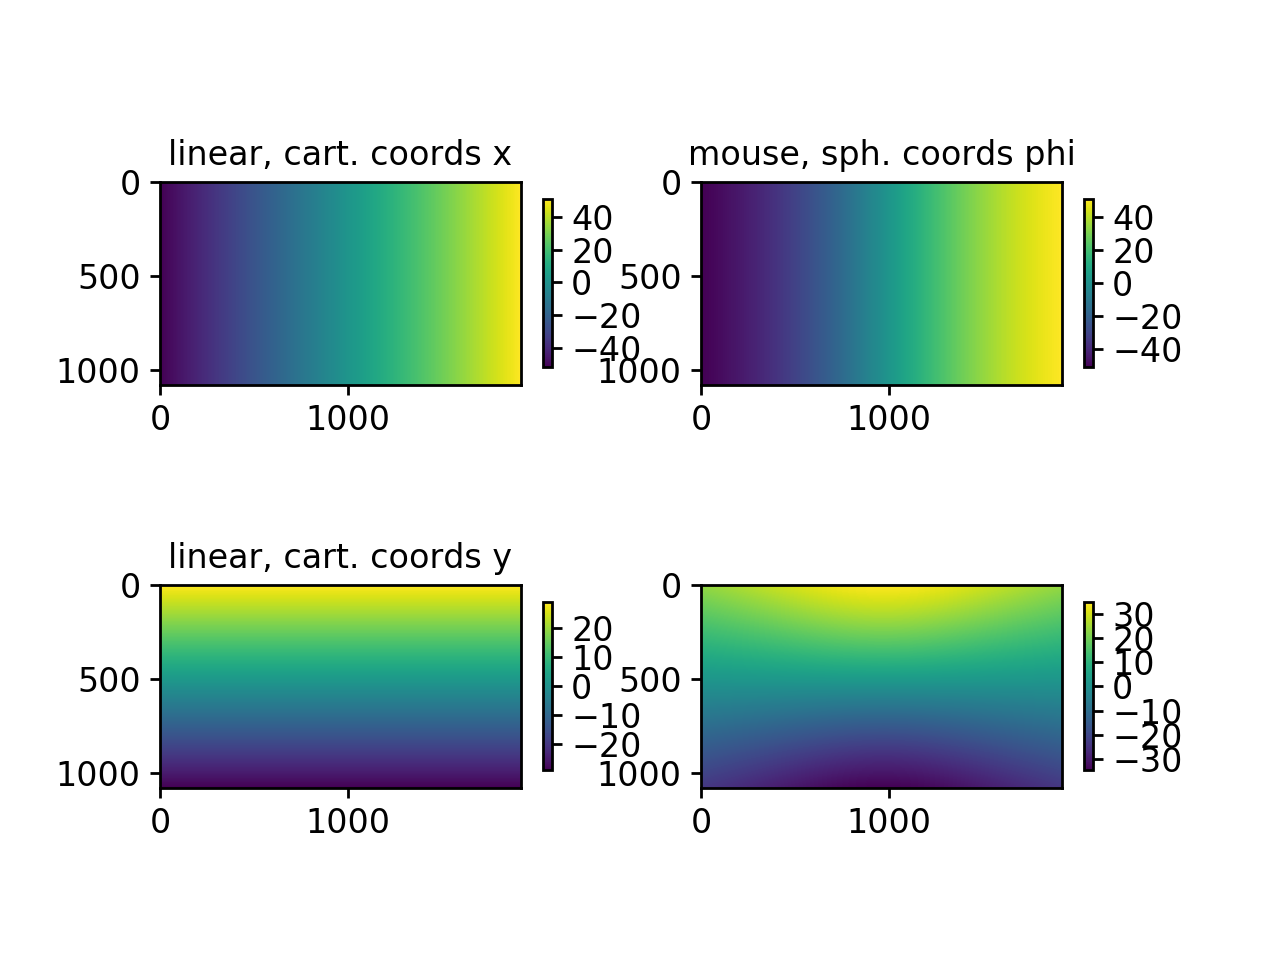

Text(0.5,1,u'mouse, sph. coords phi')

In [66]:

fig, axn = pl.subplots(2,2)

ax = axn[0,0]
im0 = ax.imshow(cart_pointsX)
pl.colorbar(im0, ax=ax, shrink=0.5)
ax.set_title("linear, cart. coords x")

ax = axn[0,1]
im1 = ax.imshow(np.rad2deg(sphr_pointsTh))
pl.colorbar(im1, ax=ax, shrink=0.5)
axn[0,1].set_title("mouse, sph. coords theta")


ax = axn[1,0]
im0 = ax.imshow(cart_pointsY)
pl.colorbar(im0, ax=ax, shrink=0.5)
ax.set_title("linear, cart. coords y")

ax = axn[1,1]
im1 = ax.imshow(np.rad2deg(sphr_pointsPh))
pl.colorbar(im1, ax=ax, shrink=0.5)
axn[0,1].set_title("mouse, sph. coords phi")


# Reverse transform

In [75]:
xmaxRad = sphr_pointsTh.max()
ymaxRad = sphr_pointsPh.max()

fx = xmaxRad/cart_pointsX.max()
fy = ymaxRad/cart_pointsY.max()

x0 = cart_pointsX*fx
y0 = cart_pointsY*fy

points = np.array( (sphr_pointsTh.flatten(), sphr_pointsPh.flatten()) ).T
values_x = cart_pointsX.flatten()
values_y = cart_pointsY.flatten()

uncorr_y = griddata( points, values_y, (x0,y0) )
uncorr_x = griddata( points, values_x, (x0,y0) )


<IPython.core.display.Javascript object>


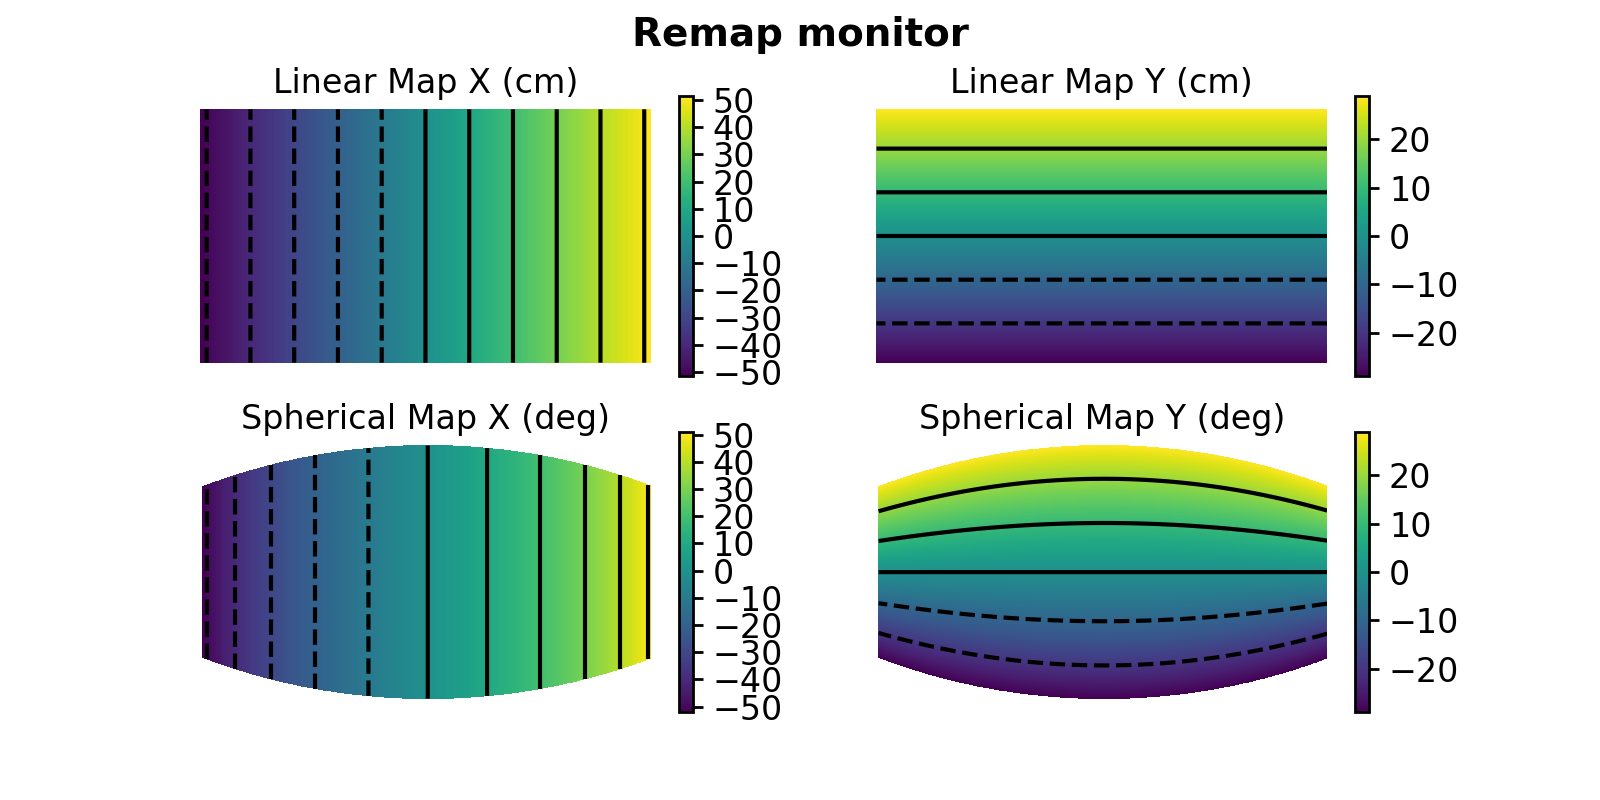

In [84]:
plot_remap(lin_coord_x, lin_coord_y, uncorr_x, uncorr_y)

In [85]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2

In [89]:
checkers = checkerboard((6,11))

In [91]:
checkers.shape

(6, 11)

In [90]:
values = checkers.flatten()
uncorr_checkers = griddata( points, values, (x0,y0) )


ValueError: different number of values and points

In [ ]:
fig, axn = pl.subplots(1,2)
im0 = axn[0].imshow(lin_coord_x)
pl.colorbar(im0, ax=axn[0], shrink=0.2)

im1 = axn[1].imshow(lin_coord_y)
pl.colorbar(im1, ax=axn[1], shrink=0.2)